In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import *
import random

import pandas as pd
import tqdm as tqdm

<ErrorbarContainer object of 3 artists>

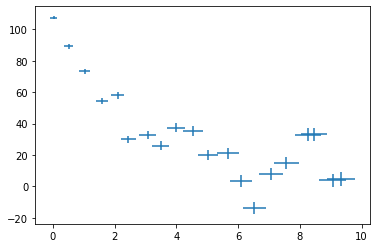

In [25]:
# Initiate some data, giving some randomness using random.random().
np.random.seed(0)
x = np.arange(0,10,.5)
y = 10+100*np.exp(-0.5*x)

xvar = .01+x/50
yvar = 1+2*x

x += np.random.normal(0,xvar,len(x))
y += np.random.normal(0,yvar,len(x))

plt.errorbar(x,y,xerr=np.sqrt(xvar),yerr=np.sqrt(yvar),linestyle="")

In [3]:
# Define a function to fit the data with.
def polynomial(p, x):
    a,b = p
    return a + b*x 

def exp_function(p, x):
    '''Calculate y at the time points xs'''
    a,b,c = p
    return a*np.exp(b*x)+c
    

In [36]:
def odr_bs(f, x, y, beta0, sx = None, sy = None, n_bs = 100):
    # Explicitly doing what ODR does internally anyway,
    # so that resampling later doesn't cause problems
    if sx is None:
        sx = np.ones_like(x)
    if sy is None:
        sy = np.ones_like(y)
    
    # Fit model f to data (x,y) with initial guess beta0 via ODR
    model = Model(f)
    data = RealData(x, y, sx=sx, sy=sy)
    odr = ODR(data, model, beta0=beta0).run()
    
    # Print results
    print("Best fit:")
    odr.pprint()
    print()
    
    # Plot best fit
    plt.errorbar(x, y, xerr=sx, yerr=sy, label="Data", linestyle="")
    xs = np.linspace(0,np.max(x),100)
    ys = f(odr.beta, xs)
    plt.plot(xs, ys, c="cornflowerblue", label="Model")
    plt.title("Best fit")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()
    
    # Bootstrapping
    bs_samples = []
    bs_odrs = []
    bs_params = []
    np.random.seed(0)
    df = pd.DataFrame({"x": x, "y": y, "sx": sx, "sy": sy})
    for _ in tqdm.tqdm(range(n_bs)):
        bs_sample = df.sample(n=len(df), replace=True)
        bs_data = RealData(bs_sample.x, bs_sample.y, sx=bs_sample.sx, sy=bs_sample.sy)
        bs_odr = ODR(bs_data, model, beta0=beta0).run()
        
        bs_samples.append(bs_sample)
        bs_odrs.append(bs_odr)
        bs_params.append(bs_odr.beta)
        
    # Plot bootstrapped models
    plt.errorbar(x, y, xerr=sx, yerr=sy, label="Data", linestyle="")
    xs = np.arange(0,np.max(x),0.1)
    for bs_odr in bs_odrs:
        ys = f(bs_odr.beta, xs)
        plt.plot(xs,ys, color="C0", alpha=.1)
    plt.title("Bootstrapped models")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()
    
    # Plot params
    pd.DataFrame(bs_params).hist()
    plt.show()
    
    # Find mean bootstrap prediction for every x value
    y_predictions = []
    for xval in x:
        selection = [xval not in bs_sample.x for bs_sample in bs_samples]
        selected_odrs = np.array(bs_odrs)[selection]
        current_predictions = [f(bs_odr.beta, xval) for bs_odr in selected_odrs]
        y_predictions.append(current_predictions)
    
    # Plot mean bootstrap prediction and calculate SSE
    plt.errorbar(x, y, xerr=sx, yerr=sy, label="Data", linestyle="")
    SSE = 0

    for xval, ytrue, ypreds in zip(x, y, y_predictions):
        plt.errorbar(xval, np.mean(ypreds), yerr=np.std(ypreds), \
                     c="0.5", marker="x", capsize=3)
        SSE += (ytrue-np.mean(ypreds))**2
    plt.title("Mean bootstrap prediction")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()
    print("SSE of mean bootstrapped prediction: ", SSE)
    

Best fit:
Beta: [101.63095724  -0.42817447   7.38453251]
Beta Std Error: [11.42891601  0.11334591  6.70795111]
Beta Covariance: [[ 1.38143303e+01 -1.58226120e-02 -2.23704037e+00]
 [-1.58226120e-02  1.35872479e-03 -6.61925078e-02]
 [-2.23704037e+00 -6.61925078e-02  4.75882276e+00]]
Residual Variance: 9.455407429106813
Inverse Condition #: 0.10697831121786296
Reason(s) for Halting:
  Sum of squares convergence



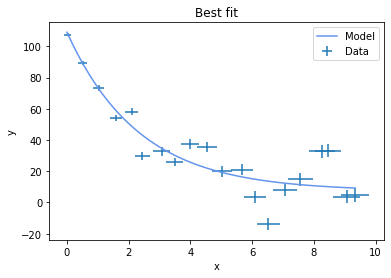

100%|████████████████████████████████| 100/100 [00:00<00:00, 648.50it/s]


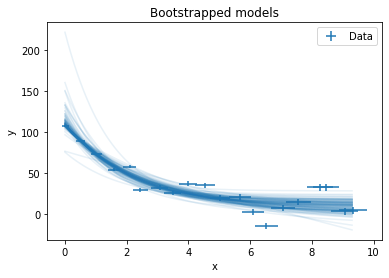

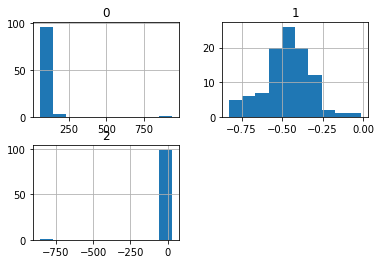

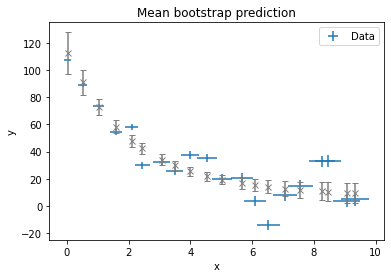

SSE of mean bootstrapped prediction:  2655.4086046612297


In [37]:
odr_bs(exp_function, x, y, sx=np.sqrt(xvar), sy=np.sqrt(yvar), beta0=[100,-0.5,10], n_bs=100)

Best fit:
Beta: [ 97.65225034 -14.50896824]
Beta Std Error: [5.76346254 1.69548564]
Beta Covariance: [[ 1.60499399 -0.32101628]
 [-0.32101628  0.13889759]]
Residual Variance: 20.696339412292712
Inverse Condition #: 0.02494303388798876
Reason(s) for Halting:
  Sum of squares convergence



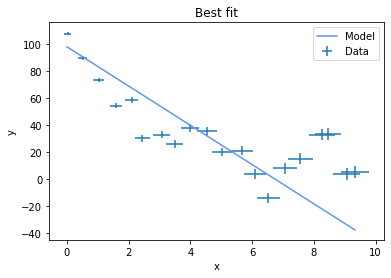

100%|████████████████████████████████| 100/100 [00:00<00:00, 948.53it/s]


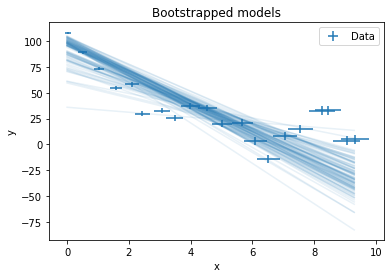

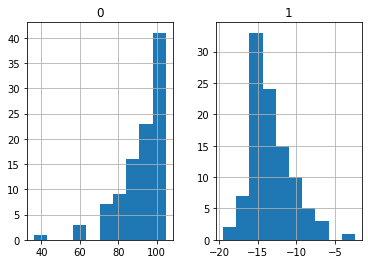

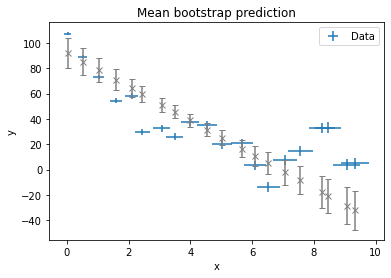

SSE of mean bootstrapped prediction:  11206.759304505687


In [38]:
odr_bs(polynomial, x, y, sx=np.sqrt(xvar), sy=np.sqrt(yvar), beta0=[100,-1], n_bs=100)